In [2]:
import numpy as np
import torch
import os
import sys
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)
torch.autograd.set_detect_anomaly(False)
# debug._set_state(False)

from botorch.optim import optimize_acqf_discrete
from botorch.models.gp_regression import SingleTaskGP
import gpytorch

from gpytorch.constraints import Interval, GreaterThan
from botorch.models.transforms.outcome import Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

# script_dir = os.path.dirname(os.path.realpath(sys.argv[0]))
cwd = os.getcwd()
src_dir = "/".join(cwd.split("/")[:-1]) # src directory is two levels up
sys.path.append(src_dir)

from src.acquisition_functions.posterior_sampling import gen_posterior_sampling_batch
from src.acquisition_functions.bax_acquisition import BAXAcquisitionFunction
# from src.fit_model import fit_model
from src.bax.alg.levelset import LevelSetEstimator
from src.performance_metrics import F1Score
from src.experiment_manager import experiment_manager
# from src.fit_model import fit_model
from src.utils import (
    generate_initial_data,
    generate_random_points,
    get_obj_vals,
    seed_torch,
    optimize_acqf_and_get_suggested_batch,
    reshape_mesh, 
    get_mesh,
    get_function_samples,
)


In [3]:
def fit_model(inputs, outputs):
    if len(outputs.shape) == 1:
        outputs = outputs.view(torch.Size([outputs.shape[0], 1]))
    model = SingleTaskGP(
        train_X=inputs,
        train_Y=outputs,
        covar_module=None,
        outcome_transform=Standardize(m=outputs.shape[-1]),
    )
    # register noise contraints to the model to be less than 1e-5
    model.likelihood.noise_covar.register_constraint(
        "raw_noise", Interval(1e-8, 1e-4)
    )
    model.covar_module.base_kernel.register_constraint(
        "raw_lengthscale", Interval(1.5e-1, 2e-1)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    return model
            

In [4]:
# means = torch.tensor([0.2, 0.5, 0.8])
# stds = torch.tensor([0.05, 0.05, 0.05])
# weights = torch.tensor([0.3, 0.4, 0.3])

seed_torch(0)

means = torch.tensor([0.3, 0.7])  # Means of the Gaussians
stds = torch.tensor([0.1, 0.15]) # Standard deviations of the Gaussians
weights = torch.tensor([0.5, 0.5]) # Weights of the Gaussians, making the left mode higher
def obj_func(x, means=means, stds=stds, weights=weights):
    if isinstance(x, np.ndarray):
        x = torch.tensor(x)
    gaussians = [w * torch.exp(-0.5 * ((x - m) / s) ** 2) / (s * torch.sqrt(torch.tensor(2 * torch.pi))) for m, s, w in zip(means, stds, weights)]
    return torch.sum(torch.stack(gaussians), dim=0)

# inputs = torch.linspace(0, 1, 8).reshape(-1, 1)
inputs = torch.tensor([
    [0.13],
    # [0.1],
    [0.2857],
    [0.47],
    [0.5714],
    [0.7143],
    [0.9],
    # [1.0000]
])
obj_vals = obj_func(inputs)

threshold = 1.1
kwargs = {}
model = fit_model(
    inputs,
    obj_vals,
)


x_set = np.linspace(0.1, 0.97, 1000).reshape(-1, 1)
algo_params = {
    "name" : "SimpleLevelSet",
    "threshold" : threshold,
    "x_set" : x_set,
    # "x_init" : x_init,
    "no_copy" : True,
}
algo = LevelSetEstimator(algo_params)

algo_gt = algo.get_copy()
exe_path_gt, output_gt = algo_gt.run_algorithm_on_f(obj_func)

batch_size = 1

In [5]:
# ps


algo_copy = algo.get_copy()
# x_next_ps = gen_posterior_sampling_batch(model, algo_copy, batch_size)
mc_values = {}
obj_func_sample = get_function_samples(model)
fsamp_vals = obj_func_sample(torch.from_numpy(x_set).unsqueeze(1)).detach().numpy() # (100, )

algo_samp = algo.get_copy()
x_output_ps = algo_samp.execute(obj_func_sample)
# get the max posterior variance of the output
var_out_post = model.posterior(torch.from_numpy(x_output_ps).unsqueeze(1)).variance.detach().numpy()
var_out_post = var_out_post.squeeze()
argmax_post = np.argmax(var_out_post)
x_max_post = x_output_ps[argmax_post].reshape(1, 1)

H_idx = np.where(fsamp_vals > threshold)[0]
H = x_set[H_idx].reshape(-1, 1)
H_values = fsamp_vals[H_idx]

L_idx = np.where(fsamp_vals <= threshold)[0]
L = x_set[L_idx].reshape(-1, 1)
L_values = fsamp_vals[L_idx]


In [6]:
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [9]:

y_true = obj_func(x_set)
posterior = model.posterior(torch.from_numpy(x_set).unsqueeze(1))
mean, var = posterior.mean.detach().squeeze().numpy(), posterior.variance.detach().squeeze().numpy()
std = np.sqrt(var)
fsamp_vals = obj_func_sample(torch.from_numpy(x_set).unsqueeze(1)).detach().numpy()

# feasible region
x1 = min(x_output_ps).item()
lh = x_output_ps[np.where(x_output_ps < 0.5)]
x2 = max(lh).item()
x3 = min(x_output_ps[np.where(x_output_ps > 0.5)]).item()
x4 = max(x_output_ps).item()
y_max_post = obj_func(x_max_post).squeeze().numpy()


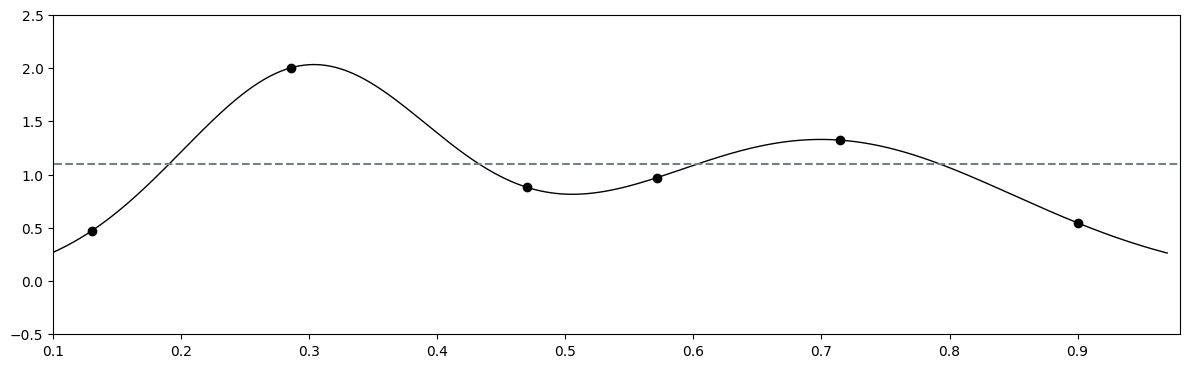

In [18]:
fig= plt.figure(figsize=(12, 5))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax = fig.add_subplot(gs[0])
ax.scatter(
    inputs, 
    obj_vals, 
    color="black", 
    label="Data"
)

ax.plot(
    x_set,
    y_true, 
    color="black",
    linewidth=1,
    label="Objective Function"
)
# ax.axhline(y=threshold, color="red", linestyle="--", label="Threshold")   
ax.plot(
    [0, 1], [threshold, threshold], color="slategrey", linestyle="--"
)


# ax.plot(
#     x_set, 
#     mean, 
#     linewidth=1,
#     # alpha=0.5,
#     color="blue",
#     label="nolegend",
# )
# ax.fill_between(x_set.flatten(), mean - 2*std, mean + 2*std, alpha=0.2)

# custom_handles = [
#     (Line2D([0.1], [0.1], color='blue'), Patch(color='blue', alpha=0.2)),
# ]


# ax.plot(
#     x_set, 
#     fsamp_vals, 
#     color="purple",
#     label="Function Sample"
# )


# # plot the feasible region on the x-axis as a grey area

# patch1 = patches.Rectangle((x1, -0.5), x2 - x1, 0.2, alpha=0.5, edgecolor='none', facecolor='grey', label="Sampled Output")
# patch2 = patches.Rectangle((x3, -0.5), x4 - x3, 0.2, alpha=0.5, edgecolor='none', facecolor='grey')
# ax.add_patch(patch1)
# ax.add_patch(patch2)


# ax2 = fig.add_subplot(gs[1], sharex=ax)
# ax2.scatter(
#     H,
#     var[H_idx],
#     color="green",
#     marker="o",
#     s=10,
#     label="Posterior Variance"
# )
# ax2.scatter(
#     L,
#     var[L_idx],
#     color="lightgreen",
#     marker="o",
#     s=10,
#     alpha=0.1,
#     # label="Posterior Variance"
# )

# plt.setp(ax.get_xticklabels(), visible=False)



# # draw a vertical line at the selected point
# ax.axvline(x=x_max_post, color="red", linestyle="-", label ="Next Point")
# ax2.axvline(x=x_max_post, color="red", linestyle="-")

# handles, labels = [], []
# next_h, next_l = None, None
# for ax_ in [ax, ax2]:
#     for h, l in zip(*ax_.get_legend_handles_labels()):
#         if l == "nolegend":
#             handles.extend(custom_handles)
#             labels.extend(["Posterior Distribution"])
#         elif l == "Next Point":
#             next_h = h
#             next_l = l
#             continue
#         else:
#             handles.append(h)
#             labels.append(l)
# handles.append(next_h)
# labels.append(next_l)
ax.set_xlim([0.1, 0.98])
ax.set_ylim([-0.5, 2.5])
plt.tight_layout()

# Create a single legend at the bottom
# fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))

plt.savefig(
    f"figs/demo_1.svg",
    bbox_inches="tight",
    # dpi=300,
)
plt.show()


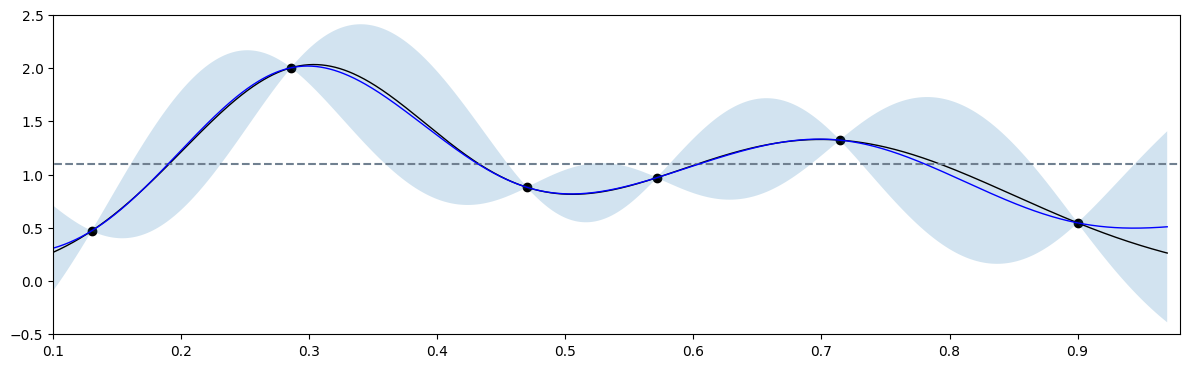

In [13]:
fig= plt.figure(figsize=(12, 5))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax = fig.add_subplot(gs[0])
ax.scatter(
    inputs, 
    obj_vals, 
    color="black", 
    label="Data"
)

ax.plot(
    x_set,
    y_true, 
    color="black",
    linewidth=1,
    label="Objective Function"
)
# ax.axhline(y=threshold, color="red", linestyle="--", label="Threshold")   
ax.plot(
    [0, 1], [threshold, threshold], color="slategrey", linestyle="--"
)


ax.plot(
    x_set, 
    mean, 
    linewidth=1,
    # alpha=0.5,
    color="blue",
    label="nolegend",
)
ax.fill_between(x_set.flatten(), mean - 2*std, mean + 2*std, alpha=0.2)

custom_handles = [
    (Line2D([0.1], [0.1], color='blue'), Patch(color='blue', alpha=0.2)),
]


# ax.plot(
#     x_set, 
#     fsamp_vals, 
#     color="purple",
#     label="Function Sample"
# )


# # plot the feasible region on the x-axis as a grey area

# patch1 = patches.Rectangle((x1, -0.5), x2 - x1, 0.2, alpha=0.5, edgecolor='none', facecolor='grey', label="Sampled Output")
# patch2 = patches.Rectangle((x3, -0.5), x4 - x3, 0.2, alpha=0.5, edgecolor='none', facecolor='grey')
# ax.add_patch(patch1)
# ax.add_patch(patch2)


# ax2 = fig.add_subplot(gs[1], sharex=ax)
# ax2.scatter(
#     H,
#     var[H_idx],
#     color="green",
#     marker="o",
#     s=10,
#     label="Posterior Variance"
# )
# ax2.scatter(
#     L,
#     var[L_idx],
#     color="lightgreen",
#     marker="o",
#     s=10,
#     alpha=0.1,
#     # label="Posterior Variance"
# )

# plt.setp(ax.get_xticklabels(), visible=False)



# # draw a vertical line at the selected point
# ax.axvline(x=x_max_post, color="red", linestyle="-", label ="Next Point")
# ax2.axvline(x=x_max_post, color="red", linestyle="-")

# handles, labels = [], []
# next_h, next_l = None, None
# for ax_ in [ax, ax2]:
#     for h, l in zip(*ax_.get_legend_handles_labels()):
#         if l == "nolegend":
#             handles.extend(custom_handles)
#             labels.extend(["Posterior Distribution"])
#         elif l == "Next Point":
#             next_h = h
#             next_l = l
#             continue
#         else:
#             handles.append(h)
#             labels.append(l)
# handles.append(next_h)
# labels.append(next_l)
ax.set_xlim([0.1, 0.98])
ax.set_ylim([-0.5, 2.5])
plt.tight_layout()

# Create a single legend at the bottom
# fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))

plt.savefig(
    f"figs/demo_2.svg",
    bbox_inches="tight",
    # dpi=300,
)
plt.show()


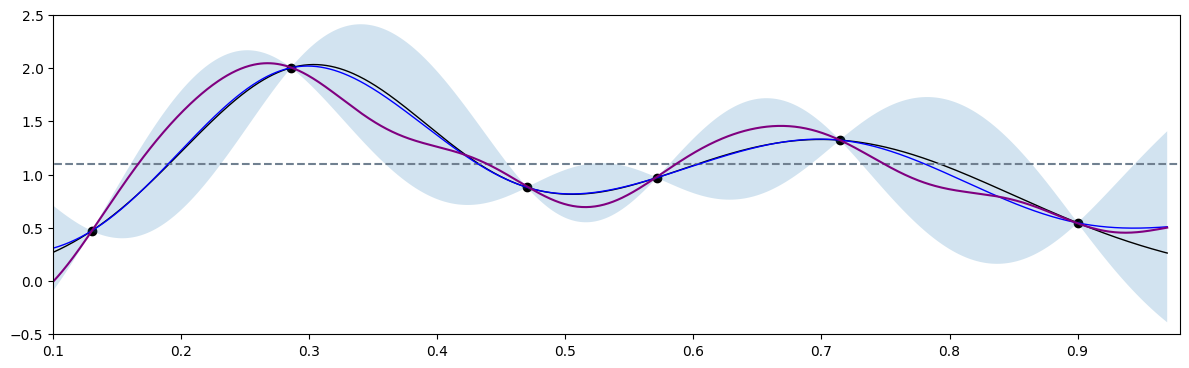

In [14]:
fig= plt.figure(figsize=(12, 5))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax = fig.add_subplot(gs[0])
ax.scatter(
    inputs, 
    obj_vals, 
    color="black", 
    label="Data"
)

ax.plot(
    x_set,
    y_true, 
    color="black",
    linewidth=1,
    label="Objective Function"
)
# ax.axhline(y=threshold, color="red", linestyle="--", label="Threshold")   
ax.plot(
    [0, 1], [threshold, threshold], color="slategrey", linestyle="--"
)


ax.plot(
    x_set, 
    mean, 
    linewidth=1,
    # alpha=0.5,
    color="blue",
    label="nolegend",
)
ax.fill_between(x_set.flatten(), mean - 2*std, mean + 2*std, alpha=0.2)

custom_handles = [
    (Line2D([0.1], [0.1], color='blue'), Patch(color='blue', alpha=0.2)),
]


ax.plot(
    x_set, 
    fsamp_vals, 
    color="purple",
    label="Function Sample"
)


# # plot the feasible region on the x-axis as a grey area

# patch1 = patches.Rectangle((x1, -0.5), x2 - x1, 0.2, alpha=0.5, edgecolor='none', facecolor='grey', label="Sampled Output")
# patch2 = patches.Rectangle((x3, -0.5), x4 - x3, 0.2, alpha=0.5, edgecolor='none', facecolor='grey')
# ax.add_patch(patch1)
# ax.add_patch(patch2)


# ax2 = fig.add_subplot(gs[1], sharex=ax)
# ax2.scatter(
#     H,
#     var[H_idx],
#     color="green",
#     marker="o",
#     s=10,
#     label="Posterior Variance"
# )
# ax2.scatter(
#     L,
#     var[L_idx],
#     color="lightgreen",
#     marker="o",
#     s=10,
#     alpha=0.1,
#     # label="Posterior Variance"
# )

# plt.setp(ax.get_xticklabels(), visible=False)



# # draw a vertical line at the selected point
# ax.axvline(x=x_max_post, color="red", linestyle="-", label ="Next Point")
# ax2.axvline(x=x_max_post, color="red", linestyle="-")

# handles, labels = [], []
# next_h, next_l = None, None
# for ax_ in [ax, ax2]:
#     for h, l in zip(*ax_.get_legend_handles_labels()):
#         if l == "nolegend":
#             handles.extend(custom_handles)
#             labels.extend(["Posterior Distribution"])
#         elif l == "Next Point":
#             next_h = h
#             next_l = l
#             continue
#         else:
#             handles.append(h)
#             labels.append(l)
# handles.append(next_h)
# labels.append(next_l)
ax.set_xlim([0.1, 0.98])
ax.set_ylim([-0.5, 2.5])
plt.tight_layout()

# Create a single legend at the bottom
# fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))

plt.savefig(
    f"figs/demo_3.svg",
    bbox_inches="tight",
    # dpi=300,
)
plt.show()


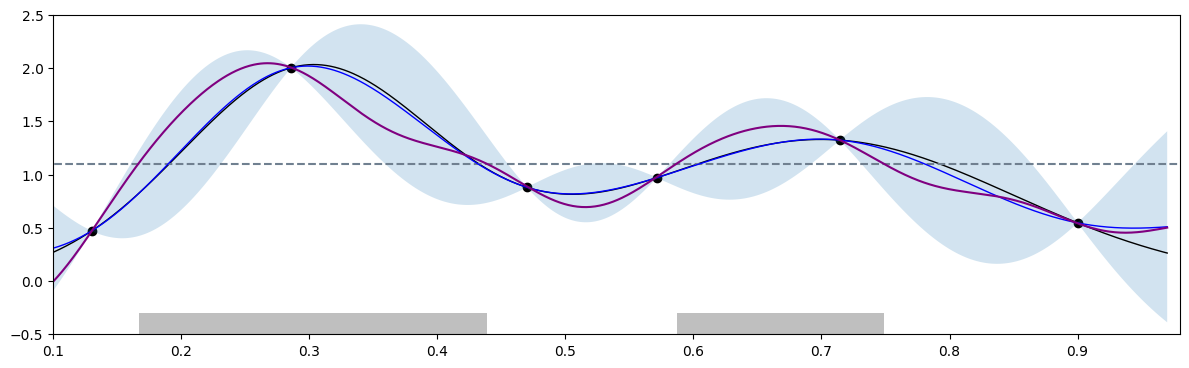

In [15]:
fig= plt.figure(figsize=(12, 5))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax = fig.add_subplot(gs[0])
ax.scatter(
    inputs, 
    obj_vals, 
    color="black", 
    label="Data"
)

ax.plot(
    x_set,
    y_true, 
    color="black",
    linewidth=1,
    label="Objective Function"
)
# ax.axhline(y=threshold, color="red", linestyle="--", label="Threshold")   
ax.plot(
    [0, 1], [threshold, threshold], color="slategrey", linestyle="--"
)


ax.plot(
    x_set, 
    mean, 
    linewidth=1,
    # alpha=0.5,
    color="blue",
    label="nolegend",
)
ax.fill_between(x_set.flatten(), mean - 2*std, mean + 2*std, alpha=0.2)

custom_handles = [
    (Line2D([0.1], [0.1], color='blue'), Patch(color='blue', alpha=0.2)),
]


ax.plot(
    x_set, 
    fsamp_vals, 
    color="purple",
    label="Function Sample"
)


# # plot the feasible region on the x-axis as a grey area

patch1 = patches.Rectangle((x1, -0.5), x2 - x1, 0.2, alpha=0.5, edgecolor='none', facecolor='grey', label="Sampled Output")
patch2 = patches.Rectangle((x3, -0.5), x4 - x3, 0.2, alpha=0.5, edgecolor='none', facecolor='grey')
ax.add_patch(patch1)
ax.add_patch(patch2)


# ax2 = fig.add_subplot(gs[1], sharex=ax)
# ax2.scatter(
#     H,
#     var[H_idx],
#     color="green",
#     marker="o",
#     s=10,
#     label="Posterior Variance"
# )
# ax2.scatter(
#     L,
#     var[L_idx],
#     color="lightgreen",
#     marker="o",
#     s=10,
#     alpha=0.1,
#     # label="Posterior Variance"
# )

# plt.setp(ax.get_xticklabels(), visible=False)



# # draw a vertical line at the selected point
# ax.axvline(x=x_max_post, color="red", linestyle="-", label ="Next Point")
# ax2.axvline(x=x_max_post, color="red", linestyle="-")

# handles, labels = [], []
# next_h, next_l = None, None
# for ax_ in [ax, ax2]:
#     for h, l in zip(*ax_.get_legend_handles_labels()):
#         if l == "nolegend":
#             handles.extend(custom_handles)
#             labels.extend(["Posterior Distribution"])
#         elif l == "Next Point":
#             next_h = h
#             next_l = l
#             continue
#         else:
#             handles.append(h)
#             labels.append(l)
# handles.append(next_h)
# labels.append(next_l)
ax.set_xlim([0.1, 0.98])
ax.set_ylim([-0.5, 2.5])
plt.tight_layout()

# Create a single legend at the bottom
# fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))

plt.savefig(
    f"figs/demo_4.svg",
    bbox_inches="tight",
    # dpi=300,
)
plt.show()


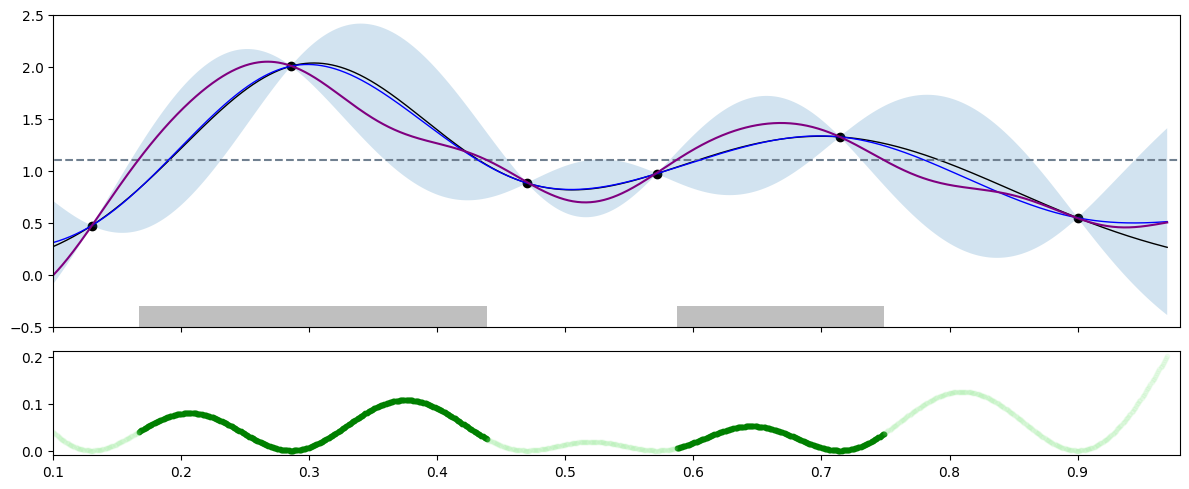

In [16]:
fig= plt.figure(figsize=(12, 5))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax = fig.add_subplot(gs[0])
ax.scatter(
    inputs, 
    obj_vals, 
    color="black", 
    label="Data"
)

ax.plot(
    x_set,
    y_true, 
    color="black",
    linewidth=1,
    label="Objective Function"
)
# ax.axhline(y=threshold, color="red", linestyle="--", label="Threshold")   
ax.plot(
    [0, 1], [threshold, threshold], color="slategrey", linestyle="--"
)


ax.plot(
    x_set, 
    mean, 
    linewidth=1,
    # alpha=0.5,
    color="blue",
    label="nolegend",
)
ax.fill_between(x_set.flatten(), mean - 2*std, mean + 2*std, alpha=0.2)

custom_handles = [
    (Line2D([0.1], [0.1], color='blue'), Patch(color='blue', alpha=0.2)),
]


ax.plot(
    x_set, 
    fsamp_vals, 
    color="purple",
    label="Function Sample"
)


# # plot the feasible region on the x-axis as a grey area

patch1 = patches.Rectangle((x1, -0.5), x2 - x1, 0.2, alpha=0.5, edgecolor='none', facecolor='grey', label="Sampled Output")
patch2 = patches.Rectangle((x3, -0.5), x4 - x3, 0.2, alpha=0.5, edgecolor='none', facecolor='grey')
ax.add_patch(patch1)
ax.add_patch(patch2)


ax2 = fig.add_subplot(gs[1], sharex=ax)
ax2.scatter(
    H,
    var[H_idx],
    color="green",
    marker="o",
    s=10,
    label="Posterior Variance"
)
ax2.scatter(
    L,
    var[L_idx],
    color="lightgreen",
    marker="o",
    s=10,
    alpha=0.1,
    # label="Posterior Variance"
)

plt.setp(ax.get_xticklabels(), visible=False)



# # draw a vertical line at the selected point
# ax.axvline(x=x_max_post, color="red", linestyle="-", label ="Next Point")
# ax2.axvline(x=x_max_post, color="red", linestyle="-")

# handles, labels = [], []
# next_h, next_l = None, None
# for ax_ in [ax, ax2]:
#     for h, l in zip(*ax_.get_legend_handles_labels()):
#         if l == "nolegend":
#             handles.extend(custom_handles)
#             labels.extend(["Posterior Distribution"])
#         elif l == "Next Point":
#             next_h = h
#             next_l = l
#             continue
#         else:
#             handles.append(h)
#             labels.append(l)
# handles.append(next_h)
# labels.append(next_l)
ax.set_xlim([0.1, 0.98])
ax.set_ylim([-0.5, 2.5])
plt.tight_layout()

# Create a single legend at the bottom
# fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))

plt.savefig(
    f"figs/demo_5.svg",
    bbox_inches="tight",
    # dpi=300,
)
plt.show()


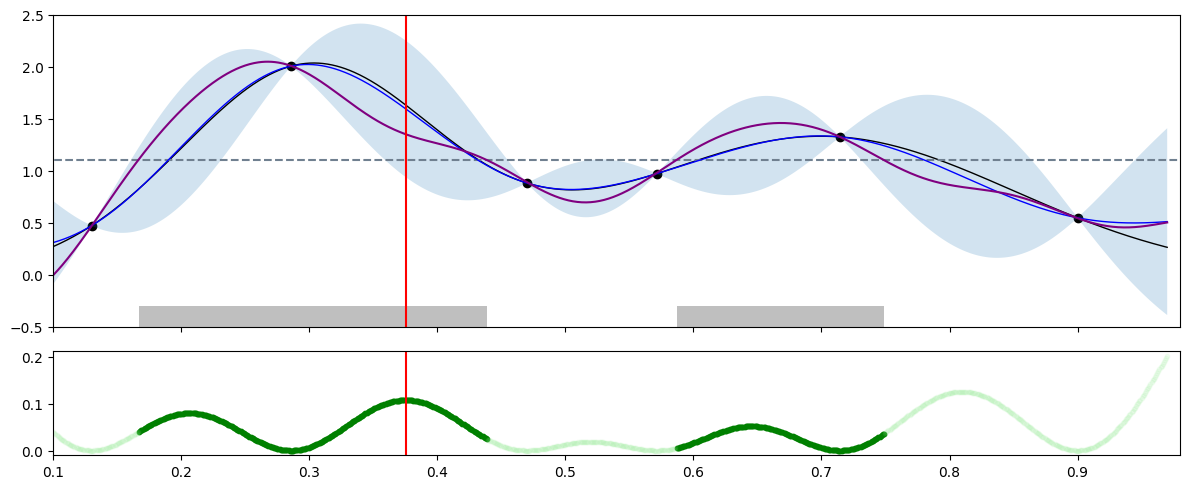

In [17]:
fig= plt.figure(figsize=(12, 5))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax = fig.add_subplot(gs[0])
ax.scatter(
    inputs, 
    obj_vals, 
    color="black", 
    label="Data"
)

ax.plot(
    x_set,
    y_true, 
    color="black",
    linewidth=1,
    label="Objective Function"
)
# ax.axhline(y=threshold, color="red", linestyle="--", label="Threshold")   
ax.plot(
    [0, 1], [threshold, threshold], color="slategrey", linestyle="--"
)


ax.plot(
    x_set, 
    mean, 
    linewidth=1,
    # alpha=0.5,
    color="blue",
    label="nolegend",
)
ax.fill_between(x_set.flatten(), mean - 2*std, mean + 2*std, alpha=0.2)

custom_handles = [
    (Line2D([0.1], [0.1], color='blue'), Patch(color='blue', alpha=0.2)),
]


ax.plot(
    x_set, 
    fsamp_vals, 
    color="purple",
    label="Function Sample"
)


# # plot the feasible region on the x-axis as a grey area

patch1 = patches.Rectangle((x1, -0.5), x2 - x1, 0.2, alpha=0.5, edgecolor='none', facecolor='grey', label="Sampled Output")
patch2 = patches.Rectangle((x3, -0.5), x4 - x3, 0.2, alpha=0.5, edgecolor='none', facecolor='grey')
ax.add_patch(patch1)
ax.add_patch(patch2)


ax2 = fig.add_subplot(gs[1], sharex=ax)
ax2.scatter(
    H,
    var[H_idx],
    color="green",
    marker="o",
    s=10,
    label="Posterior Variance"
)
ax2.scatter(
    L,
    var[L_idx],
    color="lightgreen",
    marker="o",
    s=10,
    alpha=0.1,
    # label="Posterior Variance"
)

plt.setp(ax.get_xticklabels(), visible=False)



# draw a vertical line at the selected point
ax.axvline(x=x_max_post, color="red", linestyle="-", label ="Next Point")
ax2.axvline(x=x_max_post, color="red", linestyle="-")

handles, labels = [], []
next_h, next_l = None, None
for ax_ in [ax, ax2]:
    for h, l in zip(*ax_.get_legend_handles_labels()):
        if l == "nolegend":
            handles.extend(custom_handles)
            labels.extend(["Posterior Distribution"])
        elif l == "Next Point":
            next_h = h
            next_l = l
            continue
        else:
            handles.append(h)
            labels.append(l)
handles.append(next_h)
labels.append(next_l)
ax.set_xlim([0.1, 0.98])
ax.set_ylim([-0.5, 2.5])
plt.tight_layout()

# Create a single legend at the bottom
# fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))

plt.savefig(
    f"figs/demo_6.svg",
    bbox_inches="tight",
    # dpi=300,
)
plt.show()
